# Fall 2022 Data Science Intern Challenge

To rerun this file, please ensure this [Question 1 dataset](https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0) is in the same directory as this notebook and renamed to "dataset.csv".

In [1]:
import pandas as pd
# import numpy as np
# from statistics import median
from scipy import stats
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"]= 20,20

## Question 1

On Shopify, we have exactly **100 sneaker shops**, and each of these shops sells only **one model of shoe**. We want to do some analysis of the average order value (AOV). When we look at orders data over a **30 day window**, we naively calculate an **AOV of $3145.13**. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

We will work through the following questions, the answers for which are summarised at the end:
1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
2. What metric would you report for this dataset?
3. What is its value?

We first load and preview the data.

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [4]:
df.tail()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
4995,4996,73,993,330,2,debit,2017-03-30 13:47:17
4996,4997,48,789,234,2,cash,2017-03-16 20:36:16
4997,4998,56,867,351,3,cash,2017-03-19 5:42:42
4998,4999,60,825,354,2,credit_card,2017-03-16 14:51:18
4999,5000,44,734,288,2,debit,2017-03-18 15:48:18


We see that there are 5000 rows, of which all values are non-null.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In [6]:
df.isnull().values.any()

False

Confirmed by a [Shopify blog post](https://www.shopify.ca/blog/average-order-value), the Average Order Value (AOV) refers to the mean value of all orders. We see that the AOV of 3145 noted in the question description matches the mean `order_amount` in the table.

A large standard deviation of 41282.54 suggests that the `order_amount` data is really spread out. While the difference between the quantiles (min, 25%, 50%, 75%) is fairly consistent, the max value of 704000 is far off from the value at the 75% quantile. Thus, there must be data beyond this point skewing the mean upwards.

In [7]:
df[['order_amount','total_items']].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


The existence of outliers is reinforced by the box plot for `order_amount`. We also split the `order_amount` data into buckets cut at values `[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 100000, 800000]` to get a better sense of distribution. 

We see that 52 data points within (1000, 100000] and 19 data points within (100000, 800000] skewing the mean upwards. It is also interesting to note that there are significantly less values within (0, 100] than within (100, 200].

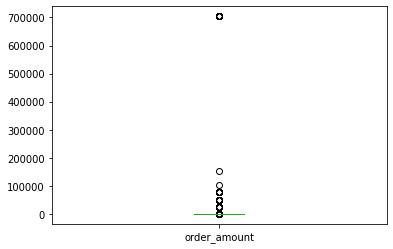

In [8]:
df['order_amount'].plot(kind='box')

In [9]:
bins = pd.cut(df['order_amount'], [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 100000, 800000])
df.groupby(bins)['order_amount'].agg(['count']).head(50)

,count
order_amount,
"(0, 100]",43
"(100, 200]",1765
"(200, 300]",855
"(300, 400]",1166
"(400, 500]",535
"(500, 600]",337
"(600, 700]",102
"(700, 800]",97
"(800, 900]",20


We have seen that compared to the mean of 3145.13, the **median** of 284 is less affected by skewed data and outliers.

As another option, by slicing off the leftmost and rightmost n% of the `order_amount` data, we can get rid of what we see as outliers before recomputing the mean. We can refer to this new mean as **n% trimmed mean**.

To choose **n%**, we can play around with the buckets we may want to remove, and find the number of data points removed as a percentage of total number of data points. 

```
(19+52) / 5000 = 0.0142
(19+52+9) / 5000 = 0.016
(19+52+9+20) / 5000 = 0.02
(19+52+9+20+97) / 5000 = 0.0394
(19+52+9+20+97+102) / 5000 = 0.0598

0.02 * 5000 = 100
```

It seems like we will stick with **2% trimmed mean**, which means removing 100 lowest and 100 highest data points.

In [10]:
stats.trim_mean(df['order_amount'], 0.02)

301.74916666666667

In some cases, it may be more important to understand the average value of a sneaker, instead of the average order value. Since the question description states "given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis" in response to a high AOV, the average sneaker value does seem desirable. To explore this scenario, we need to acknowledge the `total_items` column into our calculation, since orders can include more than 1 sneaker, and even up to **2000 sneakers**! 

We introduce a column `item_amount` to reflect the sneaker value in the order. The question description states that each shop sells only "one model of shoe", so assuming that the price would be equal for any shoe of the same model, we can compute `item_amount` as `order_amount / total_items`.

In [11]:
df['item_amount'] = df['order_amount'] / df['total_items']

Similar to analysis on the `order_amount` column, we see that `item_amount` column also contains outliers skewing the mean. So let us once again acknowledge the **median** and **2% trimmed mean** for the sneaker value.

In [12]:
df[['item_amount','order_amount','total_items']].describe()

,item_amount,order_amount,total_items
count,5000.000000,5000.000000,5000.00000
mean,387.742800,3145.128000,8.78720
std,2441.963725,41282.539349,116.32032
min,90.000000,90.000000,1.00000
25%,133.000000,163.000000,1.00000
50%,153.000000,284.000000,2.00000
75%,169.000000,390.000000,3.00000
max,25725.000000,704000.000000,2000.00000


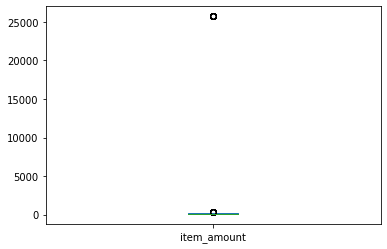

In [13]:
df[['item_amount']].plot(kind='box')

In [14]:
bins = pd.cut(df['item_amount'], [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 100000, 800000])
df.groupby(bins)['item_amount'].agg(['count']).head(50)

,count
item_amount,
"(0, 100]",97
"(100, 200]",4753
"(200, 300]",53
"(300, 400]",51
"(400, 500]",0
"(500, 600]",0
"(600, 700]",0
"(700, 800]",0
"(800, 900]",0


In [15]:
stats.trim_mean(df['item_amount'], 0.02)

151.57416666666666

### Summary

Since the top ~1.5% of the data is signifcantly higher than the rest of the data, these outliers are skewing the mean upwards. This makes the **mean** a faulty metric. Thus, the best metrics for this scenario appear to be the **median** and **2% trimmed mean**. To choose between the `order_amount` or `item_amount` will depend on context of why this metric is needed.

Metrics for `order_amount` (order value):

1. **Mean**: 3145.13

2. **Median**: 284.00

3. **2% Trimmed Mean**: 301.75

Metrics for `item_amount` (sneaker value):

1. **Mean**: 387.74

2. **Median**: 153.00

3. **2% Trimmed Mean**: 151.57

## Question 2

For this question you’ll need to use SQL. [Follow this link](https://www.w3schools.com/SQL/TRYSQL.ASP?FILENAME=TRYSQL_SELECT_ALL) to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

### 1. How many orders were shipped by Speedy Express in total?
```mySQL
SELECT COUNT(*)
FROM Orders
JOIN Shippers
USING(ShipperID)
WHERE ShipperName = "Speedy Express";
```
**Answer**: 54

### 2. What is the last name of the employee with the most orders?
```mySQL
SELECT E.LastName
FROM Orders AS O
JOIN Employees AS E
ON O.EmployeeID = E.EmployeeID
GROUP BY E.EmployeeID
ORDER BY COUNT(*) DESC
LIMIT 1;
```
**Answer**: Peacock

### 3. What product was ordered the most by customers in Germany?
```mySQL
SELECT P.ProductName
FROM Orders AS O
JOIN OrderDetails AS OD
ON O.OrderID = OD.OrderID
JOIN Products AS P
ON OD.ProductID = P.ProductID
JOIN Customers AS C
ON O.CustomerID = C.CustomerID
AND C.Country = "Germany"
GROUP BY P.ProductID
ORDER BY SUM(OD.Quantity) DESC
LIMIT 1;
```
**Answer**: Boston Crab Meat